### <div align="center">***MODEL BUILDING AND TRAINING***</div>

### ***Import libraries and modules***

In [83]:
# Import required libraries

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

import mlflow
import mlflow.data
import mlflow.sklearn

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="_distutils_hack")
warnings.filterwarnings("ignore", category=FutureWarning, module="mlflow.data")

### ***Preprocessing dataset for Modeling***

In [51]:
fe_dataset = pd.read_csv(r'C:\Users\spand\Projects\LABMENTIX_PROJECTS\Amazon_DeliveryTime_Prediction\Data\Processed\EDA_dataset.csv')

In [52]:
df = fe_dataset.copy()

# Interactive features
df['Traffic_Area'] = df['Traffic'].astype(str) + "_" + df['Area'].astype(str)
df['Area_Vehicle'] = df['Area'].astype(str) + "_" + df['Vehicle'].astype(str)
df['Weather_Area'] = df['Weather'].astype(str) + "_" + df['Area'].astype(str)

df['Peak_Hours'] = df['Order_Hour'].apply(lambda x: 1 if (17 <= x <= 23) else 0) # Create peak hours from order hours
df['Is_Urban'] = df['Area'].apply(lambda x: 1 if x in ['Urban', 'Metropolitan'] else 0) # Collapse to Binary (Urban vs Non-Urban)

df = df.drop(["Delay_Time_M", "Order_Month", "Order_DayOfWeek", "Order_Day", "Is_Weekend"], axis=1) # Drop features with no predictive power
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43648 entries, 0 to 43647
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Agent_Age      43648 non-null  int64  
 1   Agent_Rating   43648 non-null  float64
 2   Weather        43648 non-null  object 
 3   Traffic        43648 non-null  object 
 4   Vehicle        43648 non-null  object 
 5   Area           43648 non-null  object 
 6   Delivery_Time  43648 non-null  int64  
 7   Category       43648 non-null  object 
 8   Distance_km    43648 non-null  float64
 9   Order_Hour     43648 non-null  int64  
 10  Traffic_Area   43648 non-null  object 
 11  Area_Vehicle   43648 non-null  object 
 12  Weather_Area   43648 non-null  object 
 13  Peak_Hours     43648 non-null  int64  
 14  Is_Urban       43648 non-null  int64  
dtypes: float64(2), int64(5), object(8)
memory usage: 5.0+ MB


#### ***Train-Val-Test split*** 

In [53]:
# Define target
TARGET = "Delivery_Time"
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42) # First split Train (70%) & Temp (30%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42) # Second split Validation (15%) & Test (15%)

X_train, y_train = train_df.drop(columns=TARGET), train_df[TARGET]
X_val, y_val = val_df.drop(columns=TARGET), val_df[TARGET]
X_test, y_test = test_df.drop(columns=TARGET), test_df[TARGET]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (30553, 14), Val: (6547, 14), Test: (6548, 14)


### ***Prepocessing Pipeline***

#### ***Outlier Handling & Skewness Correction***

***As observed from univariate analysis, Delivery_Time, Distance_km and Order_Hour are skewed with outliers.***
- ***Delivery_Time (target):*** left untouched 
- ***Order_Hour:*** bimodal, temporal pattern → keep raw
- ***Agent_Rating:*** bounded [1–5], skew due to natural bias → keep raw 
- ***Distance_km:*** extreme skew & heavy-tailed → cap + log transform (if needed) ✅

#### ***Encode categorical features***
- ***Define low & high cardinality feature groups***
- Apply One-hot Encoding for low cardinality features
- Apply Target Encoding for high cardinality features (Interactive features)

#### ***Scaling numerical features + target-encoded features***
- Apply ***StandardScalar()*** on numerical + target-encoded features

In [54]:
# Outlier & Skew transformer
class OutlierSkewHandler(BaseEstimator, TransformerMixin):
    def __init__(self, features, skew_threshold=1.0, quantile=0.99):
        self.features = features
        self.skew_threshold = skew_threshold
        self.quantile = quantile
        self.upper_limits_ = {}
        self.log_features_ = []
        
    def fit(self, X, y=None):
        X = X.copy()
        for col in self.features:
            self.upper_limits_[col] = X[col].quantile(self.quantile)
            capped = np.where(X[col] > self.upper_limits_[col], self.upper_limits_[col], X[col])
            if pd.Series(capped).skew() > self.skew_threshold:
                self.log_features_.append(col)
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in self.features:
            X[col] = np.where(X[col] > self.upper_limits_[col], self.upper_limits_[col], X[col])
            if col in self.log_features_:
                X[col] = np.log1p(X[col])
        return X

In [55]:
# Define Preprocessing pipeline

# Feature groups
low_card_feats  = ["Weather", "Traffic", "Vehicle", "Area"]
high_card_feats = ["Category", "Traffic_Area", "Area_Vehicle", "Weather_Area"]
num_feats = ["Agent_Age", "Agent_Rating", "Distance_km", "Order_Hour"]

# Outlier/skew handler for Distance
outlier_skew = OutlierSkewHandler(features=["Distance_km"], skew_threshold=1.0)

# Encoders
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
target_enc = TargetEncoder(cols=high_card_feats)

# Column transformer (numerics + OHE)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_feats + high_card_feats),
        ("ohe", ohe, low_card_feats)
    ],
    remainder="passthrough"
)

# Full preprocessing pipeline
full_preprocessing_pipeline = Pipeline(steps=[
        ("outlier_skew", outlier_skew),
        ("encode_target", target_enc),
        ("preproc", preprocessor)
    ])

In [56]:
# Wrap full_preprocessing_pipeline + model into a new pipeline
def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessing", full_preprocessing_pipeline),
        ("model", model)
    ])

### ***Model Building, Training & Evaluation***

In [57]:
# Metrics helper functions
def metrics_report(y_true, y_pred):
    return {
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }

def print_eval(name, y_true, y_pred):
    m = metrics_report(y_true, y_pred)
    print(f"{name} -> RMSE: {m['rmse']:.4f} | MAE: {m['mae']:.4f} | R2: {m['r2']:.4f}")

#### ***Baseline Models***

In [58]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set MLflow tracking to your project root "mlruns" folder
mlflow.set_tracking_uri("file:///C:/Users/spand/Projects/LABMENTIX_PROJECTS/Amazon_DeliveryTime_Prediction/mlruns")
mlflow.set_experiment("Amazon_delivery_time_prediction")

# Define baseline models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}

2025/10/02 00:16:31 INFO mlflow.tracking.fluent: Experiment with name 'Amazon_delivery_time_prediction' does not exist. Creating a new experiment.


In [59]:
results = {}

for name, model in models.items():
    pipe = make_pipeline(model) # Wrap model with preprocessing pipeline

    with mlflow.start_run(run_name=name):
        
        pipe.fit(X_train, y_train) # Fit on train
        
        # Predictions
        preds_train = pipe.predict(X_train)
        preds_val = pipe.predict(X_val)

        # Metrics
        train_metrics = metrics_report(y_train, preds_train)
        val_metrics = metrics_report(y_val, preds_val)

        # Print results
        print(f"\n=== {name} ===")
        print_eval("Train", y_train, preds_train)
        print_eval("Val", y_val, preds_val)

        # Log metrics + params to MLflow
        mlflow.log_params(model.get_params())
        mlflow.log_metrics({f"train_{k}": v for k,v in train_metrics.items()})
        mlflow.log_metrics({f"val_{k}": v for k,v in val_metrics.items()})

        # Log model
        mlflow.sklearn.log_model(pipe, "model")

        # Save to dictionary
        results[name] = {
            "pipe": pipe,
            "train_metrics": train_metrics,
            "val_metrics": val_metrics
        }


=== LinearRegression ===
Train -> RMSE: 32.0479 | MAE: 25.2990 | R2: 0.6179
Val -> RMSE: 32.6013 | MAE: 25.8693 | R2: 0.6057

=== Ridge ===
Train -> RMSE: 32.0479 | MAE: 25.2986 | R2: 0.6179
Val -> RMSE: 32.6014 | MAE: 25.8694 | R2: 0.6057

=== RandomForest ===
Train -> RMSE: 8.4238 | MAE: 6.4339 | R2: 0.9736
Val -> RMSE: 23.2360 | MAE: 17.8425 | R2: 0.7997

=== GradientBoosting ===
Train -> RMSE: 23.6020 | MAE: 18.5169 | R2: 0.7928
Val -> RMSE: 24.2978 | MAE: 19.0656 | R2: 0.7810

=== XGBoost ===
Train -> RMSE: 17.2477 | MAE: 13.1805 | R2: 0.8893
Val -> RMSE: 23.2389 | MAE: 18.0027 | R2: 0.7997


In [60]:
# Summarize results
summary = []
for name, info in results.items():
    summary.append([
        name,
        info["train_metrics"]["rmse"], info["val_metrics"]["rmse"],
        info["train_metrics"]["mae"], info["val_metrics"]["mae"],
        info["train_metrics"]["r2"], info["val_metrics"]["r2"]
    ])

summary_df = pd.DataFrame(summary, 
                          columns=["model","train_rmse","val_rmse","train_mae","val_mae","train_r2","val_r2"])
summary_df = summary_df.sort_values("val_rmse").reset_index(drop=True)
display(summary_df)

# Pick best model (lowest val RMSE)
best_name = summary_df.loc[0,"model"]
best_pipe = results[best_name]["pipe"]
print("\nBest baseline model based on Val RMSE:", best_name)

,model,train_rmse,val_rmse,train_mae,val_mae,train_r2,val_r2
0,RandomForest,8.423772,23.236043,6.433893,17.842477,0.973601,0.799702
1,XGBoost,17.247720,23.238867,13.180513,18.002658,0.889327,0.799654
2,GradientBoosting,23.601966,24.297775,18.516883,19.065614,0.792760,0.780980
3,LinearRegression,32.047924,32.601322,25.298958,25.869305,0.617900,0.605704
4,Ridge,32.047910,32.601431,25.298628,25.869371,0.617900,0.605702



Best baseline model based on Val RMSE: RandomForest


***Validation Performance (Main Criteria)***
- The goal is to minimize Val RMSE (lower is better).
- RandomForest (23.23) and XGBoost (23.23) are nearly identical, both much better than GradientBoosting (24.29) and far better than Ridge/Linear (32+).
- So RandomForest & XGBoost are the top contenders.

***Overfitting Check***
- RandomForest: Train RMSE = 8.42 vs Val RMSE = 23.23 → Big gap → model fits training data extremely well but generalizes less strongly.
- XGBoost: Train RMSE = 17.24 vs Val RMSE = 23.23 → Smaller gap → slightly better generalization than RandomForest.
- Both still generalize well, but RandomForest shows stronger overfitting.

***R² Scores (Explained Variance)***
- RandomForest: 0.97 (train) → ~ 0.80 (val)
- XGBoost: 0.88 (train) → ~ 0.80 (val)
- Both capture ~80% of variance on validation set.

***Even though XGBoost is very close, RandomForest edges out slightly on validation RMSE (23.2360 vs 23.2388) thought it shows more overfitting (big train-val gap). So let's:***
- Get feature importances for both RandomForest and XGBoost.
- Drop weak features (low contribution).
- Hyperparameter tune both models with CV.
- Track everything in MLflow (params, metrics, datasets, models).

#### ***Extract Feature Importances***

In [61]:
def get_feature_importances(pipe, model_name):
    """
    Extract feature importances from RandomForest or XGBoost model 
    inside pipeline after preprocessing.
    """
    # Go into ColumnTransformer inside preprocessing
    col_trans = pipe.named_steps["preprocessing"].named_steps["preproc"]

    feature_names = []

    for name, trans, cols in col_trans.transformers_:
        if name == "ohe":  # OneHotEncoder
            feature_names.extend(trans.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)

    # Extract model
    model = pipe.named_steps["model"]

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        if len(importances) != len(feature_names):
            print(f"⚠️ Mismatch: {len(importances)} importances vs {len(feature_names)} features")
        feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
        feat_imp = feat_imp.sort_values("importance", ascending=False).reset_index(drop=True)

        # Plot
        plt.figure(figsize=(10,6))
        plt.barh(feat_imp["feature"][:20], feat_imp["importance"][:20])
        plt.gca().invert_yaxis()
        plt.title(f"{model_name} - Top 20 Feature Importances")
        plt.show()

        return feat_imp
    else:
        print(f"{model_name} does not provide feature_importances_")
        return None

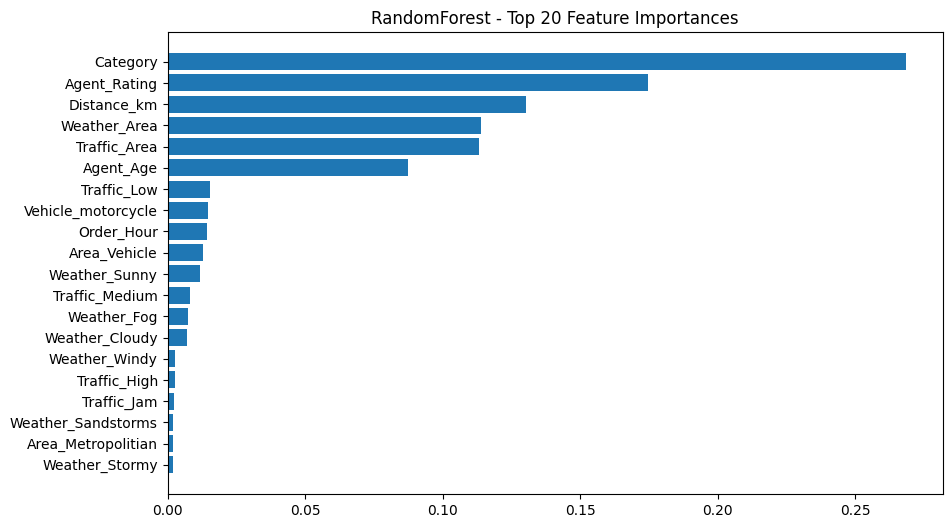

In [62]:
# RandomForest importances
rf_importances = get_feature_importances(results["RandomForest"]["pipe"], "RandomForest")

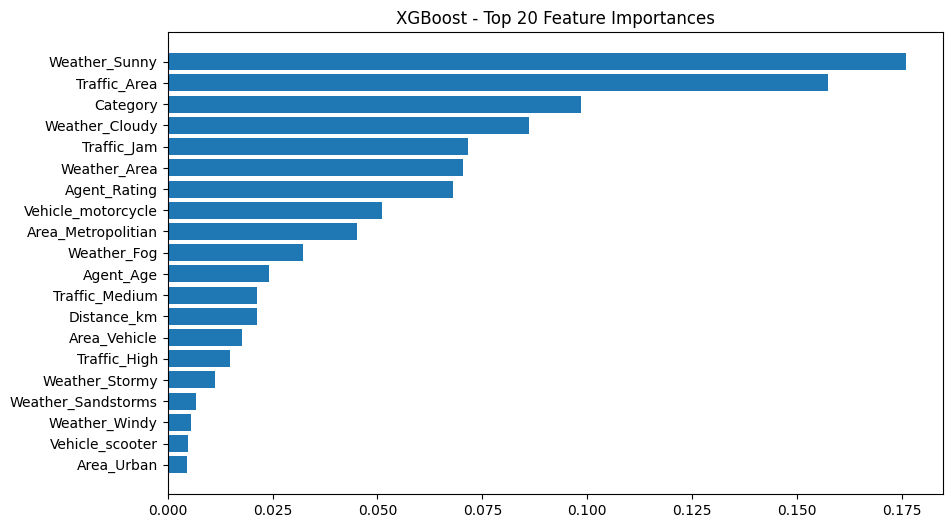

In [63]:
# XGBoost importances
xgb_importances = get_feature_importances(results["XGBoost"]["pipe"], "XGBoost")

In [64]:
# Drop features that both models agree are weak, so both models get trained on the same reduced feature set
def drop_low_importance_features(rf_importances, xgb_importances, threshold=0.01):
    """
    Find features that both RF & XGB agree have importance < threshold.
    Ensures feature names are treated as strings.
    """
    # Convert feature column to string
    rf_features = rf_importances.copy()
    rf_features["feature"] = rf_features["feature"].astype(str)
    
    xgb_features = xgb_importances.copy()
    xgb_features["feature"] = xgb_features["feature"].astype(str)
    
    # Find low importance features
    low_rf  = set(rf_features[rf_features["importance"] < threshold]["feature"])
    low_xgb = set(xgb_features[xgb_features["importance"] < threshold]["feature"])
    
    # Intersection = common weak features
    low_common = low_rf.intersection(low_xgb)
    
    print("Common low-importance features to drop:", sorted(list(low_common)))
    return list(low_common)

low_feats = drop_low_importance_features(rf_importances, xgb_importances, threshold=0.01)

Common low-importance features to drop: ['12', '13', 'Area_Other', 'Area_Semi-Urban', 'Area_Urban', 'Vehicle_scooter', 'Vehicle_van', 'Weather_Sandstorms', 'Weather_Windy']


In [67]:
col_trans = full_preprocessing_pipeline.named_steps["preproc"]
print("Transformers inside ColumnTransformer:\n")
for name, trans, cols in col_trans.transformers:
    print(f"{name}: {cols}")

Transformers inside ColumnTransformer:

num: ['Agent_Age', 'Agent_Rating', 'Distance_km', 'Order_Hour', 'Category', 'Traffic_Area', 'Area_Vehicle', 'Weather_Area']
ohe: ['Weather', 'Traffic', 'Vehicle', 'Area']


In [ ]:
def update_preprocessor_with_feature_drop(preprocessor, low_feats):
    """
    Returns a new ColumnTransformer with low-importance features removed.
    Keeps original dataset intact.
    """
    new_transformers = []
    for name, trans, cols in preprocessor.transformers:
        # Remove dropped features from each transformer’s column list
        filtered_cols = [col for col in cols if col not in low_feats]
        if filtered_cols:  # Only keep transformer if it still has columns
            new_transformers.append((name, trans, filtered_cols))
    
    # Rebuild ColumnTransformer
    return ColumnTransformer(transformers=new_transformers, remainder="drop")

# Access old preprocessor inside pipeline
old_preproc = full_preprocessing_pipeline.named_steps["preproc"]

# Create updated preprocessor
updated_preproc = update_preprocessor_with_feature_drop(old_preproc, low_feats)

# Replace in pipeline
full_preprocessing_pipeline.set_params(preproc=updated_preproc)

Pipeline(steps=[('outlier_skew', OutlierSkewHandler(features=['Distance_km'])),
                ('encode_target',
                 TargetEncoder(cols=['Category', 'Traffic_Area', 'Area_Vehicle',
                                     'Weather_Area'])),
                ('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Agent_Age', 'Agent_Rating',
                                                   'Distance_km', 'Order_Hour',
                                                   'Category', 'Traffic_Area',
                                                   'Area_Vehicle',
                                                   'Weather_Area']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Weather', 'Traffic',
                                                   'Vehicle', 'Area'])]))])

In [66]:
# Try fitting pipeline again with reduced features
test_pipe = Pipeline([
    ("preprocessing", full_preprocessing_pipeline),
    ("model", RandomForestRegressor(random_state=42))
])

test_pipe.fit(X_train, y_train)
print("Pipeline fit successful with reduced feature set.")

Pipeline fit successful with reduced feature set.


#### ***Hyperparameter Tune RF & XGB on reduced Feature set***

In [68]:
# Define CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Parameter grids
rf_param_dist = {
    "model__n_estimators": [100, 200, 400, 600],
    "model__max_depth": [5, 10, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

xgb_param_dist = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [3, 6, 10],
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__subsample": [0.7, 0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 1.0]
}

In [69]:
# Function to hp tune & log in MLflow
def hp_tune_and_log(model_name, model, param_dist, X_train, y_train, X_val, y_val):
    pipe = Pipeline([
        ("preprocessing", full_preprocessing_pipeline),
        ("model", model)
    ])

    rs = RandomizedSearchCV(
        pipe, param_distributions=param_dist, 
        n_iter=20, scoring="neg_root_mean_squared_error",
        cv=cv, random_state=42, n_jobs=-1, verbose=2
    )

    with mlflow.start_run(run_name=f"Tuned_{model_name}"):
        rs.fit(X_train, y_train)

        # Best pipeline
        best_pipe = rs.best_estimator_
        print(f"\nBest {model_name} Params: {rs.best_params_}")

        # Evaluate
        preds_train = best_pipe.predict(X_train)
        preds_val   = best_pipe.predict(X_val)

        train_metrics = metrics_report(y_train, preds_train)
        val_metrics   = metrics_report(y_val, preds_val)

        print(f"\n=== {model_name} (Tuned) ===")
        print_eval("Train", y_train, preds_train)
        print_eval("Val", y_val, preds_val)

        # Log params + metrics
        mlflow.log_params(rs.best_params_)
        mlflow.log_metrics({f"train_{k}": v for k,v in train_metrics.items()})
        mlflow.log_metrics({f"val_{k}": v for k,v in val_metrics.items()})

        # Log model
        mlflow.sklearn.log_model(best_pipe, "model")

    return best_pipe, rs.best_params_, {
        "train": train_metrics,
        "val": val_metrics
    }

In [70]:
# HP Tune Random Forest
best_rf, rf_params, rf_metrics = hp_tune_and_log(
    "RandomForest", RandomForestRegressor(random_state=42), rf_param_dist,
    X_train, y_train, X_val, y_val
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best RandomForest Params: {'model__n_estimators': 600, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 10}

=== RandomForest (Tuned) ===
Train -> RMSE: 20.7124 | MAE: 16.0116 | R2: 0.8404
Val -> RMSE: 22.1484 | MAE: 17.1417 | R2: 0.8180


In [71]:
# HP Tune XGB
best_xgb, xgb_params, xgb_metrics = hp_tune_and_log(
    "XGBoost", xgb.XGBRegressor(random_state=42, n_jobs=-1), xgb_param_dist,
    X_train, y_train, X_val, y_val
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best XGBoost Params: {'model__subsample': 0.7, 'model__n_estimators': 400, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}

=== XGBoost (Tuned) ===
Train -> RMSE: 18.9987 | MAE: 14.6598 | R2: 0.8657
Val -> RMSE: 22.4057 | MAE: 17.4339 | R2: 0.8138


In [73]:
# Compare results
results_tuned = {
    "RandomForest": {
        "params": rf_params,
        "train": rf_metrics["train"],
        "val": rf_metrics["val"]
    },
    "XGBoost": {
        "params": xgb_params,
        "train": xgb_metrics["train"],
        "val": xgb_metrics["val"]
    }
}

# Convert to DataFrame for easy comparison
summary_rows = []
for model_name, res in results_tuned.items():
    row = {
        "Model": model_name,
        "Train_RMSE": res["train"]["rmse"],
        "Val_RMSE":  res["val"]["rmse"],
        "Train_MAE": res["train"]["mae"],
        "Val_MAE":   res["val"]["mae"],
        "Train_R2":  res["train"]["r2"],
        "Val_R2":    res["val"]["r2"]
    }
    summary_rows.append(row)

results_df = pd.DataFrame(summary_rows)
results_df.set_index("Model", inplace=True)

display(results_df)

,Train_RMSE,Val_RMSE,Train_MAE,Val_MAE,Train_R2,Val_R2
Model,,,,,,
RandomForest,20.712403,22.148362,16.011564,17.141749,0.840398,0.818015
XGBoost,18.998672,22.405704,14.659768,17.433907,0.865716,0.813762


***Validation Performance (what really matters):***
- RF has slightly lower RMSE/MAE → better generalization.
- RF Val_RMSE = 22.15 vs XGB = 22.41 (small edge to RF).
- RF Val_MAE = 17.14 vs XGB = 17.43.
- Val_R² is basically the same (~0.818 vs 0.814).

***Training Performance:***
- XGB fits training data better (lower Train_RMSE/MAE, higher Train_R²).
- But that’s not necessarily good → it might be slightly overfitting compared to RF.

***✅ Best Choice -> RandomForest***
- Lower validation RMSE/MAE (your main metrics).
- Slightly more balanced (less risk of overfitting).

#### ***Retrain on Train + Val with best model parameters***

In [74]:
# Combine train + val
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f"Train + Val shape: {X_train_val.shape}, Test shape: {X_test.shape}")

Train + Val shape: (37100, 14), Test shape: (6548, 14)


In [75]:
# Refit best model pipeline on train + val
final_pipeline = best_rf
final_pipeline.fit(X_train_val, y_train_val) 

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('outlier_skew',
                                  OutlierSkewHandler(features=['Distance_km'])),
                                 ('encode_target',
                                  TargetEncoder(cols=['Category',
                                                      'Traffic_Area',
                                                      'Area_Vehicle',
                                                      'Weather_Area'])),
                                 ('preproc',
                                  ColumnTransformer(transformers=[('num',
                                                                   StandardScaler(),
                                                                   ['Agent_Age',
                                                                    'Agent_Rating',
                                                                    'Distance_km',
                                                                    'Order_Hour',
                                                                    'Category',
                                                                    'Traffic_Area',
                                                                    'Area_Vehicle',
                                                                    'Weather_Area']),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Weather',
                                                                    'Traffic',
                                                                    'Vehicle',
                                                                    'Area'])]))])),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=2,
                                       n_estimators=600, random_state=42))])

In [79]:
# Evaluate on train + val and on test

preds_train_val = final_pipeline.predict(X_train_val)
train_val_metrics = metrics_report(y_train_val, preds_train_val)
print_eval("Train + Val", y_train_val, preds_train_val)

# Final evaluation on test (use only once)
preds_test = final_pipeline.predict(X_test)
test_metrics = metrics_report(y_test, preds_test)
print_eval("Test", y_test, preds_test)

Train + Val -> RMSE: 20.8913 | MAE: 16.1432 | R2: 0.8377
Test -> RMSE: 22.0196 | MAE: 16.9701 | R2: 0.8230


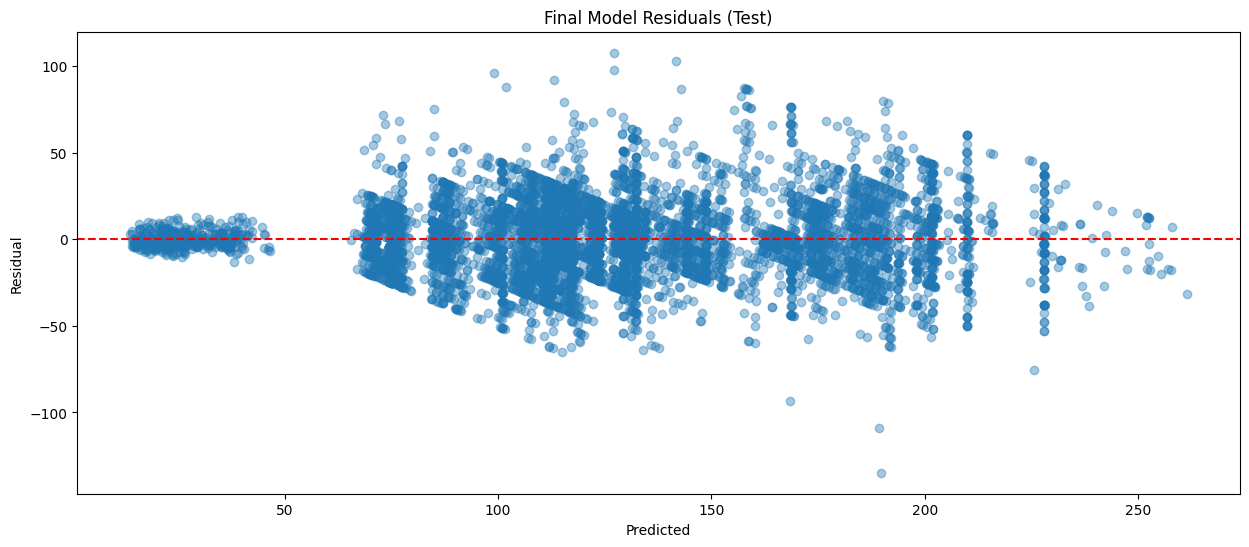

In [80]:
# Residual plot for test
plt.figure(figsize=(15,6))
resid = y_test - preds_test
plt.scatter(preds_test, resid, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Final Model Residuals (Test)")
plt.show()

#### ***Interpretation***

***Consistency (Good Generalization)***
- Train+Val RMSE = 20.9 vs Test RMSE = 22.0 → only a small gap.
- Train+Val R² = 0.838 vs Test R² = 0.823 → very close.
- ✅ Model is not overfitting; generalizes well to unseen data.

***Error Magnitude***
- RMSE ~22 hours → predictions deviate by ~22 hours on average.
- MAE ~17 hours → median absolute error is lower (robust to outliers).
- Considering delivery times may range widely (short vs long trips), this error seems reasonable — since long-distance orders exist.

***Residual Plot***
- Residuals are mostly centered around 0 (good).
- Spread increases with higher predicted values (heteroscedasticity).
- Suggests model handles short/medium deliveries better, but variance grows for long delivery times (common in real logistics data).

***Conclusion***
- Hyperparameter tuned RandomForest model is performing very well
- Balanced fit (Train ≈ Test metrics).
- Captures ~82% of variance in delivery times.
- Errors are relatively stable across test set.

In [85]:
# Log everything to MLflow (datasets + params + metrics + model)
from mlflow.models.signature import infer_signature

with mlflow.start_run(run_name=f"Final_{type(final_pipeline.named_steps['model']).__name__}_TrainVal"):
    
    # Log parameters
    try:
        mlflow.log_params(final_pipeline.named_steps["model"].get_params())
    except Exception:
        mlflow.log_param("model", str(final_pipeline.named_steps["model"]))

    # Log metrics
    mlflow.log_metrics({
        "train_val_rmse": train_val_metrics["rmse"],
        "train_val_mae": train_val_metrics["mae"],
        "train_val_r2":  train_val_metrics["r2"],
        "test_rmse":    test_metrics["rmse"],
        "test_mae":     test_metrics["mae"],
        "test_r2":      test_metrics["r2"]
    })

    # Log datasets (reduced features)
    try:
        # Train+Val combined
        train_val_final = pd.concat([X_train_val, y_train_val], axis=1)
        test_final     = pd.concat([X_test, y_test], axis=1)

        train_val_ds = mlflow.data.from_pandas(train_val_final, name="trainval_dataset_final")
        test_ds     = mlflow.data.from_pandas(test_final, name="test_dataset_final")

        mlflow.log_input(train_val_ds, context="train_val")
        mlflow.log_input(test_ds, context="test")

    except Exception as e:
        print("Warning: mlflow.data logging failed:", e)
        train_val_final.to_csv("train_val_final.csv", index=False)
        test_final.to_csv("test_final.csv", index=False)
        mlflow.log_artifact("train_val_final.csv", artifact_path="datasets_final")
        mlflow.log_artifact("test_final.csv", artifact_path="datasets_final")

    # Save kept features
    try:
        col_trans = final_pipeline.named_steps["preprocessing"].named_steps["preproc"]
        feature_names = []
        for name, trans, cols in col_trans.transformers_:
            if hasattr(trans, "get_feature_names_out"):
                try:
                    feature_names.extend(list(trans.get_feature_names_out(cols)))
                except Exception:
                    feature_names.extend(list(cols))
            else:
                feature_names.extend(list(cols))
        kept_feats = pd.DataFrame({"kept_features": feature_names})
        kept_feats.to_csv("kept_features.csv", index=False)
        mlflow.log_artifact("kept_features.csv", artifact_path="preprocessing")
    except Exception as e:
        print("Warning writing kept_features.csv:", e)

    # Log final model (with schema)
    signature = infer_signature(X_train_val, final_pipeline.predict(X_train_val))
    mlflow.sklearn.log_model(final_pipeline, "final_model_pipeline", signature=signature)

    # Save locally for Streamlit
    model_output_path = "../Models"
    os.makedirs(model_output_path, exist_ok=True)
    local_model_path = os.path.join(
        model_output_path,
        f"final_pipeline_{type(final_pipeline.named_steps['model']).__name__}.joblib"
    )
    joblib.dump(final_pipeline, local_model_path)
    print("Saved final pipeline to", local_model_path)

print("✅ Final run logged to MLflow with Train+Val and Test datasets.")

c:\Users\spand\Projects\LABMENTIX_PROJECTS\Amazon_DeliveryTime_Prediction\.venv\lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\spand\Projects\LABMENTIX_PROJECTS\Amazon_DeliveryTime_Prediction\.venv\lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). In

Saved final pipeline to ../Models\final_pipeline_RandomForestRegressor.joblib
✅ Final run logged to MLflow with Train+Val and Test datasets.
